In [62]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [63]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

In [64]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [65]:
wiki_api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

In [66]:
wiki_tool.invoke("what is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [67]:
from dotenv import load_dotenv
load_dotenv()

import os 

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct_Agent"

In [68]:
## Custom Functions
def multiply(a:int,b:int)->int:
    """ 
    Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a*b 

# This will be a tool
def add(a:int,b:int)->int:
    """ 
    Adds a and b

    Args: 
        a: first int
        b: second int
    """
    return a+b 

def divide(a:int,b:int)->float:
    """
    Divide a and b

    Args:
        a:first int
        b:second int 
    """
    return a/b 



In [69]:
## Tavily search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

In [70]:
tavily.invoke("recent news on war")

[{'title': 'Ukraine-Russia war latest: New prisoner swap agreed in Istanbul ...',
  'url': 'https://www.independent.co.uk/news/world/europe/ukraine-russia-war-trump-putin-prisoner-swap-nato-sumy-latest-b2777994.html',
  'content': "Ukraine-Russia war latest: New prisoner swap agreed in Istanbul includes return of 'heroes of Mariupol' On the frontline, Putin's advance in Sumy has been halted by recent Ukrainian successes",
  'score': 0.5585443},
 {'title': 'Countries Currently at War / Countries at War 2025',
  'url': 'https://worldpopulationreview.com/country-rankings/countries-currently-at-war',
  'content': 'On April 22, 2022, Russian officials revealed that Russiaâ\x80\x99s goal was to take control of the southeastern portion of Ukraine. Annexing this region would establish a land bridge between Russia and the Crimean peninsula, which it had previously annexed in 2014.\n\n## Countries Currently at War (as of September 2022)\n\n### Category: 10,000+ casualties in 2022\n\n### Myanmar 

In [71]:
# Combining all the tools
tools=[tavily,arxiv_tool,wiki_tool,add,multiply,divide]

In [72]:
## Initializing the LLM model
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A404A4D1F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A404A51E80>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [73]:
# Binding tools with LLM
llm_with_tools=llm.bind_tools(tools)

In [74]:
from pprint import pprint 
from langchain_core.messages import AIMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ek3jbbnqm', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1703, 'total_tokens': 1791, 'completion_time': 0.16, 'prompt_time': 0.059912056, 'queue_time': 0.254110314, 'total_time': 0.219912056}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--735e7b35-84c8-48b8-9cda-25a7171d3844-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'ek3jbbnqm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1703, 'output_tokens': 88, 'total_tokens': 1791})

In [75]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'cv1vm34t1',
  'type': 'tool_call'}]

In [76]:
from typing_extensions import TypedDict, Annotated
from typing import List
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]


In [77]:
# Combining all the tools
tools=[tavily,arxiv_tool,wiki_tool,add,multiply,divide]

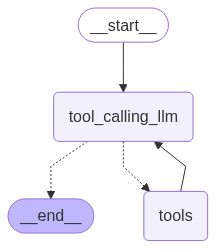

In [78]:
## Entire Chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


#Build graph
graph=StateGraph(State)

# Add Nodes
graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

# Add edges
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)


## MAJORRRRR change in ReAct Agent Architecture
graph.add_edge("tools","tool_calling_llm")

final_graph=graph.compile()

# Display

display(Image(final_graph.get_graph().draw_mermaid_png()))

In [79]:
messages=final_graph.invoke({"messages":HumanMessage(content="What is recent news about india,add 2 plus 2 then multiply by 100")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is recent news about india,add 2 plus 2 then multiply by 100
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (yag4yh5jq)
 Call ID: yag4yh5jq
  Args:
    query: recent news about india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "India | Latest News & Updates - BBC", "url": "https://www.bbc.com/news/world/asia/india", "content": "The BBC's Samira Hussain reports from a hospital where the dead and injured have been taken.\n\n## Latest updates\n\nAircraft debris at the crash site of Air India Ltd. flight AI171 in Ahmedabad, Gujarat, India, on Thursday, June 12, 2025. An Air India Boeing 787 Dreamliner traveling from Ahmedabad to London's Gatwick airport crashed shortly after taking off, in what stands to be the most serious accident involving the US 

In [80]:
messages=final_graph.invoke({"messages":HumanMessage(content="What is Machine Learning")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is Machine Learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (8mx377b2d)
 Call ID: 8mx377b2d
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a field of stu

In [81]:
messages

{'messages': [HumanMessage(content='What is Machine Learning', additional_kwargs={}, response_metadata={}, id='04fb6a3a-00a4-4e84-a140-3009d5e699aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8mx377b2d', 'function': {'arguments': '{"query":"Machine Learning"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 1701, 'total_tokens': 1781, 'completion_time': 0.145454545, 'prompt_time': 0.072241551, 'queue_time': 0.25419242799999997, 'total_time': 0.217696096}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ce0f7a3d-d0eb-445a-8b31-078fb5991d31-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Machine Learning'}, 'id': '8mx377b2d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1701, 'output_tokens': 80, 'total_tokens': 1781}),
  ToolMessage(content='Page: Machine learning\nSummary: Machine learning 

In [82]:
messages=final_graph.invoke({"messages":HumanMessage(content="Add 2 and 4")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 2 and 4
================================== Ai Message ==================================
Tool Calls:
  add (0s6n1sged)
 Call ID: 0s6n1sged
  Args:
    a: 2
    b: 4
================================= Tool Message =================================
Name: add

6
================================== Ai Message ==================================
Tool Calls:
  multiply (m3n485vqd)
 Call ID: m3n485vqd
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: multiply

42
================================== Ai Message ==================================

42


### Here we are getting wronge or no answers due to no history 

In [83]:
'''messages=final_graph.invoke({"messages":HumanMessage(content="please multiply that by 2")})

for m in messages["messages"]:
    m.pretty_print()'''

'messages=final_graph.invoke({"messages":HumanMessage(content="please multiply that by 2")})\n\nfor m in messages["messages"]:\n    m.pretty_print()'

# Memory Saver in LangGrpah

In [84]:
## Entire Chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


#Build graph
graph=StateGraph(State)

# Add Nodes
graph.add_node("tool_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

# Add edges
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)


## MAJORRRRR change in ReAct Agent Architecture
graph.add_edge("tools","tool_calling_llm")


## Enabling the Memory Saver

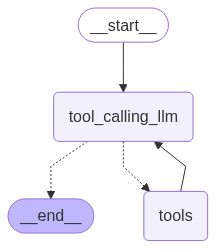

In [85]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_with_memory=graph.compile(checkpointer=memory)

display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

In [86]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}

messages=[HumanMessage(content="Add 3 and 4")]

messages=graph_with_memory.invoke({"messages":messages},config=config)

for m in messages["messages"]:
    m.pretty_print()



================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (297bxhtme)
 Call ID: 297bxhtme
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (2bepqxh28)
 Call ID: 2bepqxh28
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


In [87]:
config={"configurable":{"thread_id":"1"}}
messages=graph_with_memory.invoke({"messages":HumanMessage(content="please multiply that by 2")},config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (297bxhtme)
 Call ID: 297bxhtme
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (2bepqxh28)
 Call ID: 2bepqxh28
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7
================================ Human Message =================================

please multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (bkvp4nkd6)
 Call ID: bkvp4nkd6
  Args:
    a: 7
    b: 2
================================= Tool Message ===